In [1]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

from DAE_helper import OrigamiDatasetGenerate,ToTensor,Grayscale

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# from shutil import copyfile
# num_imgs = 3

# lists = list(os.listdir('/home/rohit/projects/autoencoder/OrigamiData/Images'))
# for i,file in enumerate(lists):
#     copyfile('/home/rohit/projects/autoencoder/OrigamiData/Images/'+file, '/home/rohit/projects/autoencoder/sample_dataset/'+file)
#     if i == num_imgs:
#         break

In [3]:
class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE,self).__init__()
        self.ec1 = nn.Linear(100*100, 512)
        self.ec2 = nn.Linear(512, 256)
        self.ec3 = nn.Linear(256, 128)
        self.ec4 = nn.Linear(128, 64)
        
        self.dc1 = nn.Linear(64, 128)
        self.dc2 = nn.Linear(128, 256)
        self.dc3 = nn.Linear(256, 512)
        self.dc4 = nn.Linear(512, 100*100)

    def forward(self, x):
        orig_size =  x.shape
        x = x.view(orig_size[0], -1).float()
        x = self.ec1(x)
        x = F.relu(x)
        x = self.ec2(x)
        x = F.relu(x)
        x = self.ec3(x)
        x = F.relu(x)
        x = self.ec4(x)
        encoded = F.relu(x)

        x = self.dc1(encoded)
        x = F.relu(x)
        x = self.dc2(x)
        x = F.relu(x)
        x = self.dc3(x)
        x = F.relu(x)
        x = self.dc4(x)
        reconst = x#F.relu(x)
        return reconst

In [4]:
train_batch_size = 4
test_batch_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([ToTensor(),Grayscale()])
origami = OrigamiDatasetGenerate(root_dir="sample_dataset",transform=trns)

train_loader = DataLoader(origami, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

torch.Size([2, 100, 100])


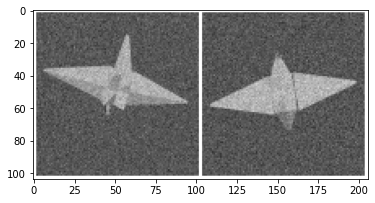

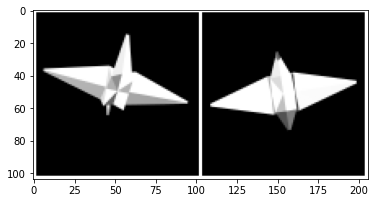

In [5]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']
print(original.shape)
augmented,original = augmented.unsqueeze(1),original.unsqueeze(1)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images_show = 8

imshow(torchvision.utils.make_grid(augmented[:images_show,:], nrow=4, padding=2, pad_value=1))
imshow(torchvision.utils.make_grid(original[:images_show,:], nrow=4, padding=2, pad_value=1))

In [6]:
def train(model, device, train_loader, optimizer, epoch,log_interval=100):
    model.train()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        print(target.shape)
        data, target = data.to(device), target.to(device).view(target.shape[0],-1)
#         print(target.shape)
        optimizer.zero_grad()
        output = model(data)
#         print(target.shape, output.shape)
        loss = F.mse_loss(output, target, reduction='mean')

        loss.backward()
        optimizer.step()
        if batch_idx % (40000//(train_batch_size*10)) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for sample in test_loader:
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device).view(target.shape[0],-1)
            output = model(data)
            test_loss += F.mse_loss(output,target, reduction='mean') # sum up batch loss


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

In [7]:
model = DenoisingAE().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=10)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

save_model = False
epochs = 100

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, train_loader)

if save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")


torch.Size([2, 100, 100])
Train Epoch: 1 [0/2 (0%)]	Loss: 0.119588

Test set: Average loss: 0.0594

torch.Size([2, 100, 100])
Train Epoch: 2 [0/2 (0%)]	Loss: 0.118884

Test set: Average loss: 0.0591

torch.Size([2, 100, 100])
Train Epoch: 3 [0/2 (0%)]	Loss: 0.118209

Test set: Average loss: 0.0588

torch.Size([2, 100, 100])
Train Epoch: 4 [0/2 (0%)]	Loss: 0.117552

Test set: Average loss: 0.0584

torch.Size([2, 100, 100])
Train Epoch: 5 [0/2 (0%)]	Loss: 0.116899

Test set: Average loss: 0.0581

torch.Size([2, 100, 100])
Train Epoch: 6 [0/2 (0%)]	Loss: 0.116242

Test set: Average loss: 0.0578

torch.Size([2, 100, 100])
Train Epoch: 7 [0/2 (0%)]	Loss: 0.115574

Test set: Average loss: 0.0574

torch.Size([2, 100, 100])
Train Epoch: 8 [0/2 (0%)]	Loss: 0.114886

Test set: Average loss: 0.0571

torch.Size([2, 100, 100])
Train Epoch: 9 [0/2 (0%)]	Loss: 0.114173

Test set: Average loss: 0.0567

torch.Size([2, 100, 100])
Train Epoch: 10 [0/2 (0%)]	Loss: 0.113424

Test set: Average loss: 0.0563


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed


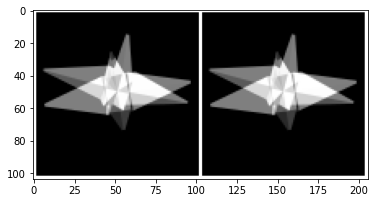

Original


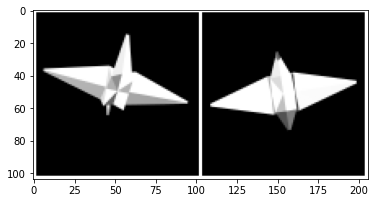

In [12]:
def cross_validation(model, device, test_loader,viewer=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        data, target = sample['augmented'],sample['original']
        
        data, target = data.to(device), target.to(device)
        output = model(data).view(target.shape[0],100,100)
        
        output, target  = output.unsqueeze(1), target.unsqueeze(1)

    if viewer:
        images_show = 8
        print('Reconstructed')
        op = output[:images_show,:].cpu()
        
        
        imshow(torchvision.utils.make_grid(op, nrow=4, padding=2, pad_value=1))
        
        print('Original')
        imshow(torchvision.utils.make_grid(target[:images_show,:].cpu(), nrow=4, padding=2, pad_value=1))
    return target, output

target, output = cross_validation(model, device, train_loader,viewer=True)